In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az


sns.set_style("whitegrid")

## Проверяем модели


In [2]:
train_reg = pd.read_csv('regression/train_reg.csv')
X_train = train_reg['x'].values
y_train = train_reg['y'].values

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ε]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 17 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.693,0.314,-1.287,-0.119,0.005,0.004,3657.0,3862.0,1.0
β,3.082,0.048,2.990,3.170,0.001,0.001,3844.0,3898.0,1.0
ε,1.693,0.124,1.472,1.938,0.002,0.001,4729.0,4424.0,1.0


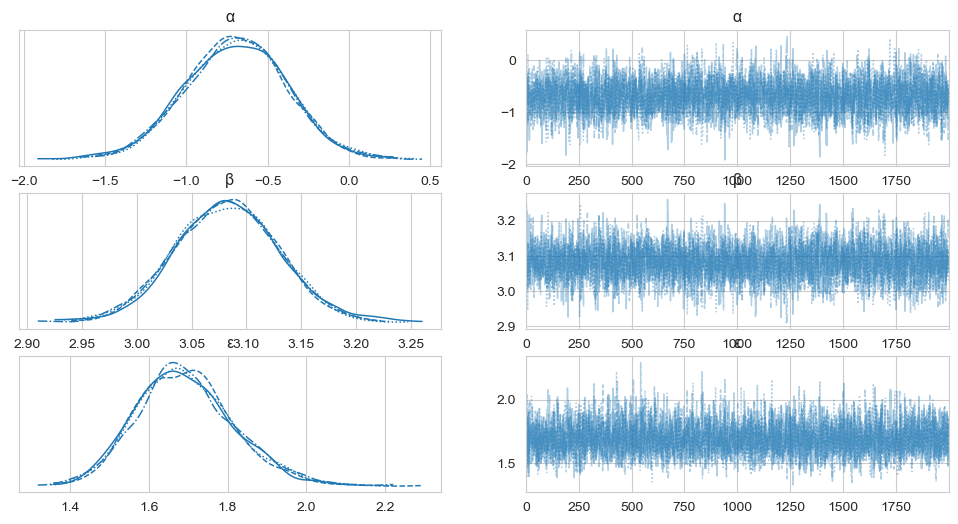

In [3]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=1, sigma=1)
    ε = pm.HalfNormal('ε', 10)
    μ = pm.Deterministic('μ', α + β * X_train)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=ε, observed=y_train)
    trace_g = pm.sample(2000, tune=2000, chains=4, cores=4)

az.plot_trace(trace_g, var_names=['α', 'β', 'ε']);
az.summary(trace_g).head(3)

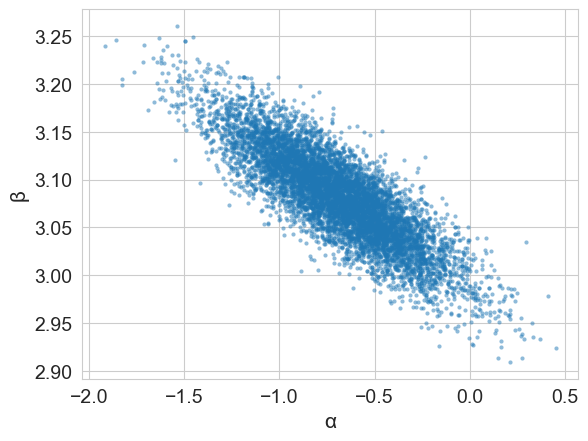

In [4]:
az.plot_pair(trace_g, var_names=['α', 'β'], scatter_kwargs={'alpha': 0.5});

Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>Metropolis: [α]
>Metropolis: [β]
>Metropolis: [ε]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.663,0.304,-1.252,-0.085,0.018,0.013,292.0,339.0,1.01
β,3.078,0.047,2.989,3.165,0.003,0.002,277.0,346.0,1.02
ε,1.698,0.118,1.487,1.921,0.003,0.002,1233.0,1254.0,1.00


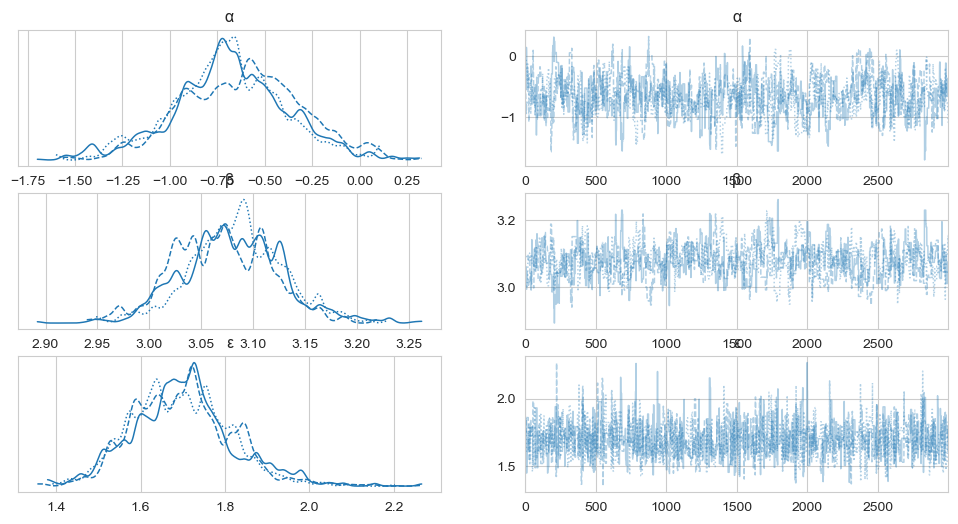

In [5]:
with pm.Model() as model_m:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=1, sigma=1)
    ε = pm.HalfNormal('ε', 10)
    μ = pm.Deterministic('μ', α + β * X_train)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=ε, observed=y_train)
    trace_m = pm.sample(3000, tune=1000, step = pm.Metropolis())

az.plot_trace(trace_m, var_names=['α', 'β', 'ε']);
az.summary(trace_m).head(3)

Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>Metropolis: [α]
>Metropolis: [β]
>Metropolis: [ε]


Sampling 3 chains for 1_000 tune and 5_000 draw iterations (3_000 + 15_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.001,0.016,-0.028,0.030,0.0,0.0,1322.0,1436.0,1.0
β,0.989,0.015,0.960,1.017,0.0,0.0,1384.0,982.0,1.0
ε,0.154,0.011,0.133,0.174,0.0,0.0,1865.0,2036.0,1.0


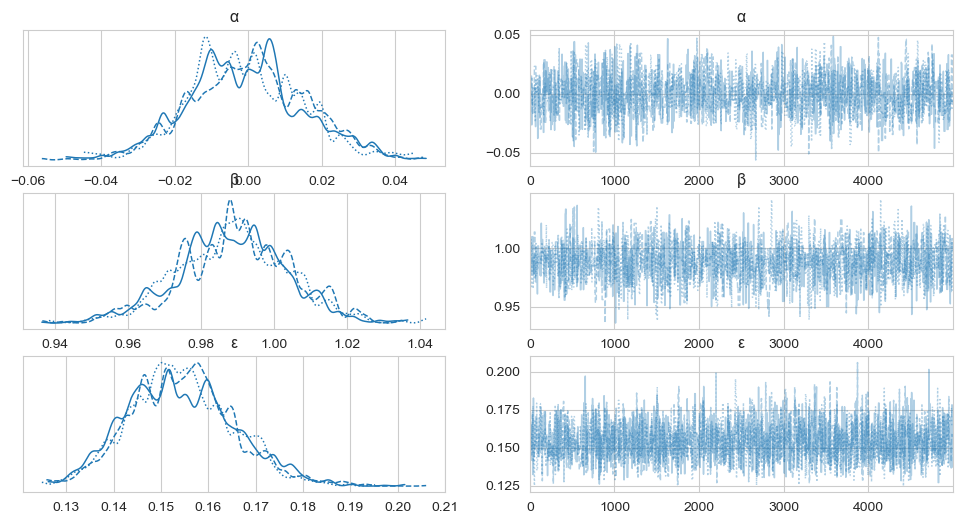

In [6]:
xm = X_train.mean()
xs = X_train.std()
ym = y_train.mean()
ys = y_train.std()

with pm.Model() as model_m:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=1, sigma=1)
    ε = pm.HalfNormal('ε', 10)
    μ = pm.Deterministic('μ', α + β * (X_train-xm)/xs)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=ε, observed=(y_train-ym)/ys)
    trace_m = pm.sample(5000, step = pm.Metropolis() )

az.plot_trace(trace_m, var_names=['α', 'β', 'ε']);
az.summary(trace_m).head(3)

всего трасс :  8000


/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


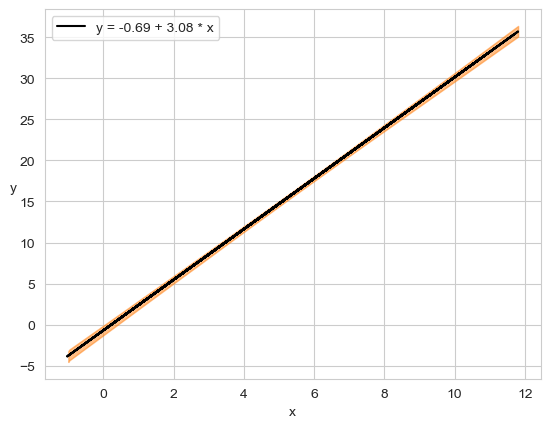

In [7]:
posterior_g = az.extract(trace_g)


alpha_m = posterior_g['α'].mean().item()
beta_m  = posterior_g['β'].mean().item()

print("всего трасс : ", posterior_g.sample.size)

draws = range(0, posterior_g.sample.size, 100)
plt.plot(X_train, alpha_m + beta_m * X_train, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

sig = az.plot_hdi(X_train, posterior_g['μ'].T, hdi_prob=0.94)

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend();

Sampling: [y_pred]


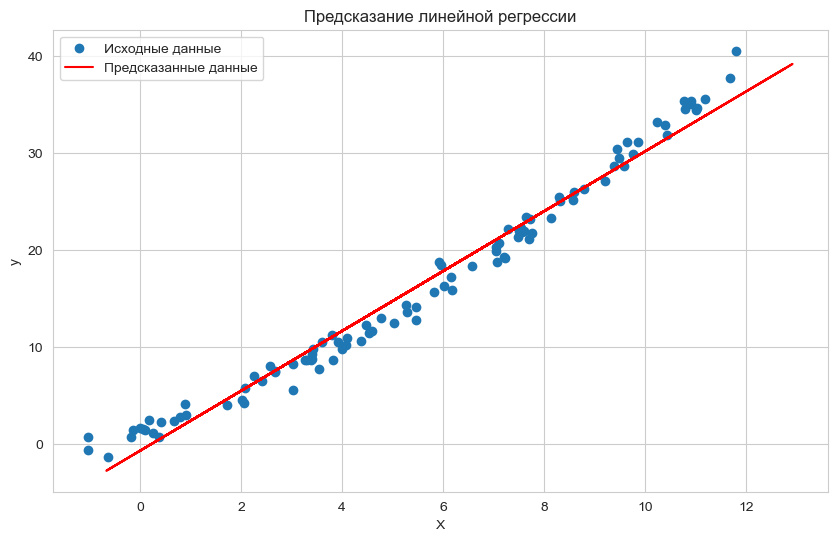

In [8]:
ppc = pm.sample_posterior_predictive(trace_g, model=model_g)

alpha = trace_g.posterior['α'].mean(("chain", "draw")).values
betta = trace_g.posterior["β"].mean(("chain", "draw")).values

X_test = pd.read_csv('regression/test_reg.csv') 

y_pred_test = alpha + betta * X_test

plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, label='Исходные данные')
plt.plot(X_test, y_pred_test, color='red', label='Предсказанные данные')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title('Предсказание линейной регрессии')
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [α_tmp, β, ε, ν_]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


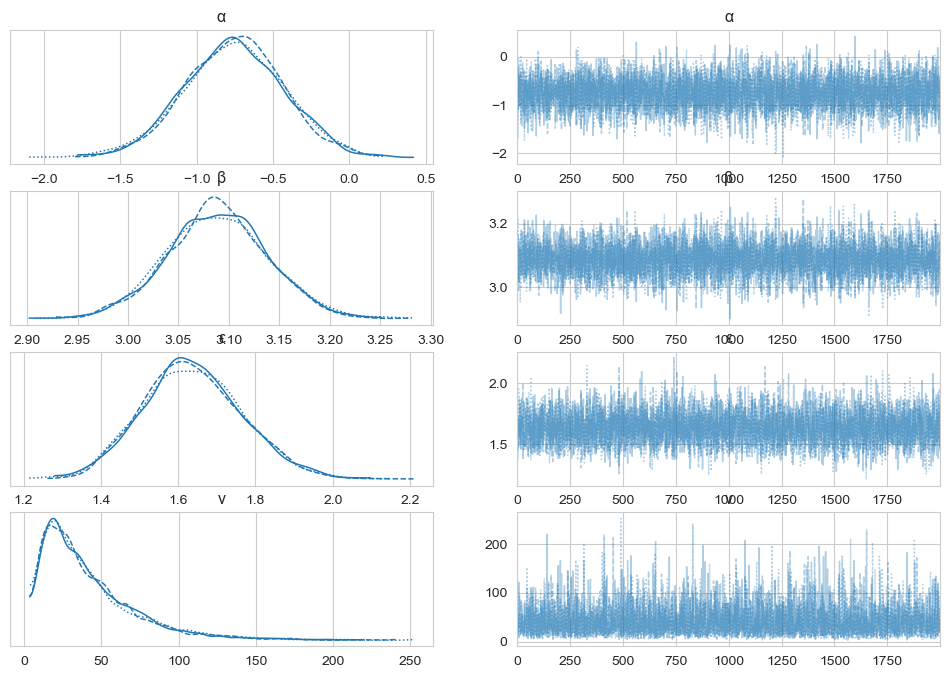

In [9]:
x_centered = X_train - X_train.mean()

with pm.Model() as model_t:
    α_tmp = pm.Normal('α_tmp', mu=0, sigma=10) 
    β = pm.Normal('β', mu=1, sigma=10)
    ε = pm.HalfNormal('ε', 5)
    ν_ = pm.Exponential('ν_', 1/30)
    ν = pm.Deterministic('ν', ν_+1)

    y_pred = pm.StudentT('y_pred', mu=α_tmp + β * x_centered,
                         sigma=ε, nu=ν, observed=y_train)

    α = pm.Deterministic('α', α_tmp - β * X_train.mean())

    trace_t = pm.sample(2000, chains=3)

varnames = ['α', 'β', 'ε', 'ν']
az.plot_trace(trace_t, var_names=varnames);

In [10]:
pm.sample_posterior_predictive(trace_t, model=model_t, extend_inferencedata=True)
pm.sample_posterior_predictive(trace_g, model=model_g, extend_inferencedata=True)
y_t = trace_t.posterior_predictive['y_pred']
y_g = trace_g.posterior_predictive['y_pred']

Sampling: [y_pred]


Sampling: [y_pred]


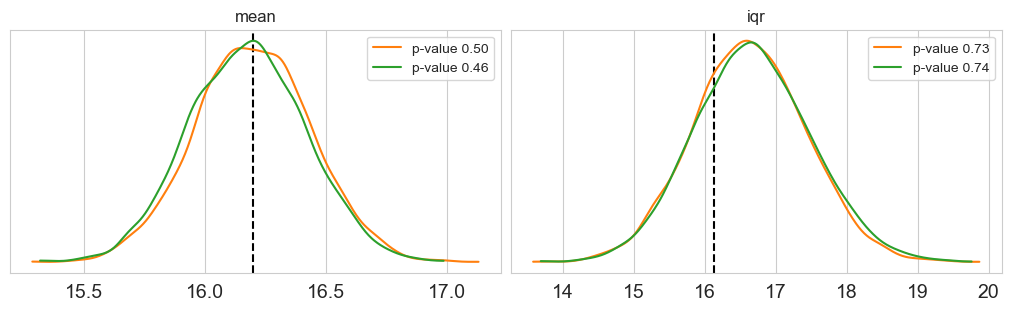

In [11]:

fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)

# МАГИЧЕСКАЯ команда распаковки кортежа для его распаковки и передачи вычисления
def iqr(x, axis=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=axis))

y_g_chain = y_g.stack(samples=('chain', 'draw')).values.T
y_t_chain = y_t.stack(samples=('chain', 'draw')).values.T

for idx, func in enumerate([np.mean, iqr]):
    T_obs = func(y_train)
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    for d_sim, c in zip([y_g_chain, y_t_chain], ['C1', 'C2']):
        T_sim = func(d_sim, 1)
        p_value = np.mean(T_sim >= T_obs)
        az.plot_kde(T_sim, plot_kwargs={'color': c},
                    label=f'p-value {p_value:.2f}', ax=ax[idx])
    ax[idx].set_title(func.__name__)
    ax[idx].set_yticks([])
    ax[idx].legend()

## Сравниваем по критериям

In [12]:
pm.compute_log_likelihood(trace_g, model=model_g)
pm.compute_log_likelihood(trace_t, model=model_t)

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [13]:
diff_loo = az.compare({"model_g": trace_g, 'model_t':trace_t})
diff_loo

/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_g,0,-195.643718,3.384722,0.000000,1.000000e+00,7.022732,0.00000,False,log
model_t,1,-195.988373,3.447258,0.344656,1.110223e-16,6.927207,0.49767,False,log


/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


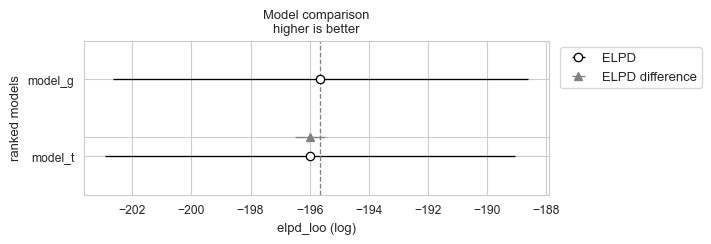

In [14]:
az.plot_compare(diff_loo);

In [15]:
diff_waic = az.compare({"model_g": trace_g, 'model_t':trace_t}, ic = 'waic')
diff_waic

/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
model_g,0,-195.621351,3.362356,0.000000,1.0,7.013959,0.000000,True,log
model_t,1,-195.972047,3.430932,0.350695,0.0,6.921937,0.495905,True,log


### Результат

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 16 jobs)
NUTS: [α, β, ε]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 17 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.706,0.316,-1.295,-0.128,0.005,0.004,3773.0,3977.0,1.0
β,3.085,0.048,2.997,3.179,0.001,0.001,3780.0,3935.0,1.0
ε,1.694,0.124,1.474,1.937,0.002,0.001,4446.0,3125.0,1.0


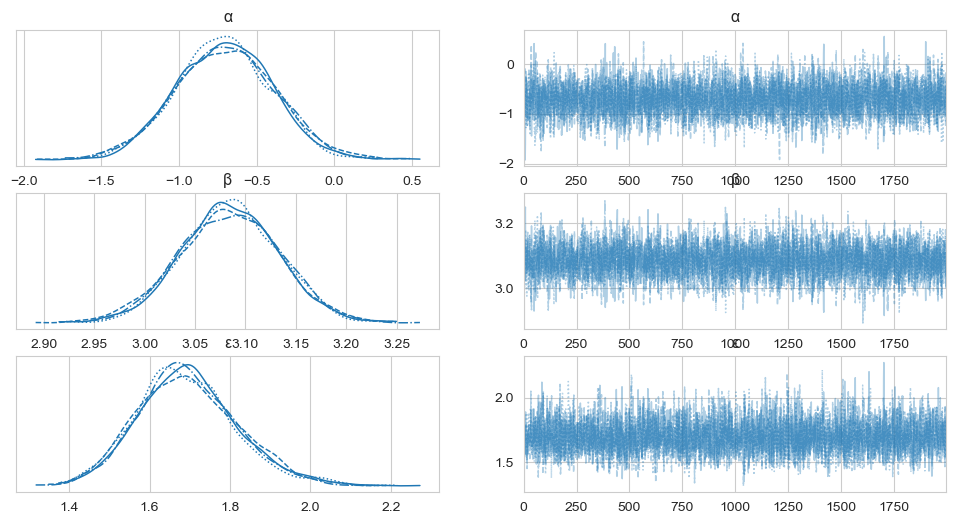

In [16]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=1, sigma=1)
    ε = pm.HalfNormal('ε', 10)
    μ = pm.Deterministic('μ', α + β * X_train)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=ε, observed=y_train)
    trace_g = pm.sample(2000, tune=2000, chains=4, cores=16)

az.plot_trace(trace_g, var_names=['α', 'β', 'ε']);
az.summary(trace_g).head(3)

In [17]:
alpha = trace_g.posterior['α'].mean(("chain", "draw")).values
betta = trace_g.posterior["β"].mean(("chain", "draw")).values

X_test = pd.read_csv('regression/test_reg.csv')

y_pred_test = alpha + betta * X_test

In [19]:
from sklearn.metrics import mean_squared_error
y_true = pd.read_csv('test_Y_true_reg.csv')
mean_squared_error(y_true, y_pred_test)

2.366197293381554